# Preparation

In [ ]:
# นำเข้าไลบรารีที่จำเป็น
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [ ]:
# ดาวน์โหลดไฟล์ข้อมูล
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2023-08-26 09:27:32--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip.1’

book-crossings.zip. 100%[===================>]  24.88M   162MB/s    in 0.2s    

2023-08-26 09:27:32 (162 MB/s) - ‘book-crossings.zip.1’ saved [26085508/26085508]

Archive:  book-crossings.zip
replace BX-Book-Ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [ ]:
# อ่านข้อมูลหนังสือเข้า DataFrame
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

# อ่านข้อมูลเรตติ้งเข้า DataFrame
df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

# Explore the Data

## Explore `df_books`

In [ ]:
# แสดง 5 แถวแรกของข้อมูลหนังสือ
df_books.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [ ]:
# แสดง 5 แถวสุดท้ายของข้อมูลหนังสือ
df_books.tail()

,isbn,title,author
271374,0440400988,There's a Bat in Bunk Five,Paula Danziger
271375,0525447644,From One to One Hundred,Teri Sloat
271376,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker
271377,0192126040,Republic (World's Classics),Plato
271378,0767409752,A Guided Tour of Rene Descartes' Meditations o...,Christopher Biffle


In [ ]:
# แสดงข้อมูลสรุปของชุดข้อมูลหนังสือ
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   isbn    271379 non-null  object
 1   title   271379 non-null  object
 2   author  271378 non-null  object
dtypes: object(3)
memory usage: 6.2+ MB


## Explore `df_ratings`

In [ ]:
df_ratings.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [ ]:
df_ratings.tail()

,user,isbn,rating
1149775,276704,1563526298,9.0
1149776,276706,0679447156,0.0
1149777,276709,0515107662,10.0
1149778,276721,0590442449,10.0
1149779,276723,05162443314,8.0


In [ ]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   user    1149780 non-null  int32  
 1   isbn    1149780 non-null  object 
 2   rating  1149780 non-null  float32
dtypes: float32(1), int32(1), object(1)
memory usage: 17.5+ MB


# Data Cleaning

**The instructions:**

"ลบผู้ใช้ที่มีคะแนนน้อยกว่า 200 คะแนนและหนังสือที่มีคะแนนน้อยกว่า 100 คะแนนออกจากชุดข้อมูล"

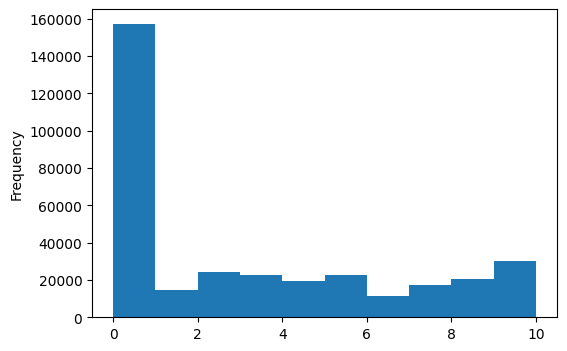

In [ ]:
# แสดงกราฟฮิสโตแกรมของเรตติ้งหนังสือก่อนทำความสะอาดข้อมูล
book_rating_before_cleaned = df_ratings.groupby("isbn")["rating"].mean()
book_rating_before_cleaned.plot.hist(column=["rating"], figsize=(6, 4));

### Clean the data according to the instructions

In [ ]:
# ลบผู้ใช้ที่มีเรตติ้งน้อยกว่า 200 รายการ
user_counts = df_ratings['user'].value_counts()
users_to_keep = user_counts[user_counts >= 200].index
user_mask = df_ratings['user'].isin(users_to_keep)

# ลบหนังสือที่มีเรตติ้งน้อยกว่า 100 รายการ
book_ratings_counts = df_ratings['isbn'].value_counts()
books_to_keep = book_ratings_counts[book_ratings_counts >= 100].index
book_mask = df_ratings['isbn'].isin(books_to_keep)

# กรองข้อมูลเรตติ้งตามเงื่อนไข
filtered_df_ratings = df_ratings[user_mask & book_mask]

In [ ]:
# แสดงข้อมูลสรุปของชุดข้อมูลเรตติ้งที่กรองแล้ว
filtered_df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49781 entries, 1456 to 1147441
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   user    49781 non-null  int32  
 1   isbn    49781 non-null  object 
 2   rating  49781 non-null  float32
dtypes: float32(1), int32(1), object(1)
memory usage: 1.1+ MB


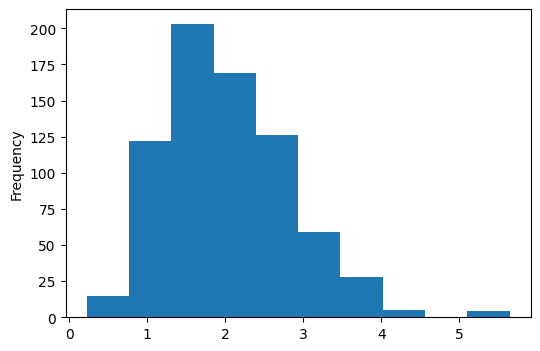

In [ ]:
# แสดงกราฟฮิสโตแกรมของเรตติ้งหนังสือหลังทำความสะอาดข้อมูล

book_rating_after_cleaned = filtered_df_ratings.groupby("isbn")["rating"].mean()
book_rating_after_cleaned.plot.hist(column=["rating"], figsize=(6, 4));

# Modeling

In [ ]:
# เชื่อมข้อมูลหนังสือกับข้อมูลเรตติ้งที่กรองแล้ว
merged_data = filtered_df_ratings.merge(df_books, on='isbn')
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49517 entries, 0 to 49516
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   user    49517 non-null  int32  
 1   isbn    49517 non-null  object 
 2   rating  49517 non-null  float32
 3   title   49517 non-null  object 
 4   author  49517 non-null  object 
dtypes: float32(1), int32(1), object(3)
memory usage: 1.9+ MB


In [ ]:
# สร้างตาราง pivot แสดงความสัมพันธ์ระหว่างชื่อหนังสือและผู้ใช้ โดยข้อมูลคือเรตติ้ง
rating_books_pivot = merged_data.pivot_table(index='title', columns='user', values='rating').fillna(0)
rating_books_pivot.head()


user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# สร้างโมเดล Nearest Neighbors โดยใช้ cosine similarity เป็นตัววัดความคล้ายคลึง
model_nn = NearestNeighbors(metric="cosine", algorithm="brute")

# ฝึกโมเดลด้วยข้อมูล pivot table
model_nn.fit(rating_books_pivot)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
# ทดสอบหาหนังสือที่คล้ายกับ "Where the Heart Is (Oprah's Book Club (Paperback))"
distances, indices = model_nn.kneighbors(rating_books_pivot.loc[["Where the Heart Is (Oprah's Book Club (Paperback))"]],
                                        6, return_distance=True)
# แสดงผลลัพธ์หนังสือที่คล้ายคลึง
for i in range(len(indices[0])):
  print(rating_books_pivot.index[indices[0][i]]+" : "+str(distances[0][i]))

Where the Heart Is (Oprah's Book Club (Paperback)) : 0.0
The Lovely Bones: A Novel : 0.7234864
I Know This Much Is True : 0.7677075
The Surgeon : 0.7699411
The Weight of Water : 0.77085835
I'll Be Seeing You : 0.8016211


# Project Submission

In [ ]:
# ฟังก์ชันสำหรับคืนค่าหนังสือที่แนะนำ
def get_recommends(book = ""):
  # ค้นหาหนังสือที่คล้ายคลึง
  distances, indices = model_nn.kneighbors(rating_books_pivot.loc[["Where the Heart Is (Oprah's Book Club (Paperback))"]],
                                          6, return_distance=True)

  recommendations = []
  result = [book, recommendations]

  # เพิ่มหนังสือที่แนะนำพร้อมระยะห่าง (ค่าความคล้ายคลึง)
  for i in range(len(indices[0])):
    recommendations.insert(0, [rating_books_pivot.index[indices[0][i]], round(distances[0][i],2)])

  return result

In [ ]:
# ทดสอบฟังก์ชัน
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

# ทดสอบว่าผ่านโจทย์ของโปรเจคหรือไม่
def test_book_recommendation():
  # ตรวจสอบว่าคำแนะนำถูกต้องตามเกณฑ์
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8], ['The Weight of Water', 0.77], ['The Surgeon', 0.77], ['I Know This Much Is True', 0.77], ['The Lovely Bones: A Novel', 0.72], ["Where the Heart Is (Oprah's Book Club (Paperback))", 0.0]]]
You passed the challenge! 🎉🎉🎉🎉🎉
